In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import pandas as pd
import os
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 获取训练数据集的特征

### 构造Dataset加载数据集

In [3]:
class MyDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        """
            csv_file: 标签文件的路径.
            root_dir: 所有图片的路径.
            transform: 一系列transform操作
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        # print(self.data_frame.info) # 可以查看通过pandas读取后的data_frame具体包含些什么

    def __getitem__(self, idx):
        '''获取图片'''
        img_path = os.path.join(self.root_dir, 
                                self.data_frame.iloc[idx, 0]) #获取图片所在路径          
        img = Image.open(img_path).convert('RGB')   # 防止有些图片不是RGB格式
        
        '''获取标签'''
        label_number = self.data_frame.iloc[idx, 1] # 获取图片的类别标签
        if label_number==-1:
            label_number=0
        '''判断是否要进行图像变换'''
        if self.transform:
            img = self.transform(img)

        return img, label_number # 返回图片和标签

    def __len__(self):
        return len(self.data_frame) # 返回数据集长度用来建立索引idx

### 将数据转换为tensor类型，并进行正则化操作

In [4]:
data_transform = transforms.Compose([
                                    #transforms.RandomHorizontalFlip(0.5),
                                    transforms.Resize((224,224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                    ]
)

### 读入数据集，将数据集划分为训练集和验证集

In [6]:
'''调用自己的Dataset类来读取数据'''
dataset = MyDataset(csv_file="../input/bitmoji-faces-gender-recognition/train.csv",
                          root_dir="../input/bitmoji-faces-gender-recognition/BitmojiDataset/trainimages",
                          transform=data_transform)

In [8]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset,[2400,600],torch.Generator().manual_seed(0))

### 将模型放在gpu上训练

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epoch = 10
batch_size = 60

### 以60张图片为1个批次

In [11]:
'''将读取好的数据进行加载'''                          
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size) # 加载数据集
val_iter = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size)

## 构建网络模型进行训练

# ResNet

In [12]:
class BasicBlock(nn.Module):
    expansion = 1
    # 输入通道，输出通道，步长，下采样
    def __init__(self,in_channel,out_channel,stride=1,downsample=None):
        super(BasicBlock,self).__init__()
        self.conv1=nn.Conv2d(in_channels=in_channel,out_channels=out_channel,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(out_channel)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=out_channel,out_channels=out_channel,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2=nn.BatchNorm2d(out_channel)
        self.downsample = downsample
    
    def forward(self,x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out=self.conv2(out)
        out=self.bn2(out)
        
        out+=identity
        out=self.relu(out)
        return out

In [14]:
class ResNet(nn.Module):
    def __init__(self,block,blocks_nums,num_classes=2,include_top=True):
        super(ResNet,self).__init__()
        self.in_channel = 64
        self.include_top = include_top
        self.conv1=nn.Conv2d(3,self.in_channel,kernel_size=7,stride=2,padding=3,bias=False)
        self.bn1=nn.BatchNorm2d(self.in_channel)
        self.relu=nn.ReLU(inplace=True)
        self.maxpool=nn.MaxPool2d(kernel_size=3,stride=2,padding=1)
        self.layer1=self._make_layer(block,64,blocks_nums[0])
        self.layer2=self._make_layer(block,128,blocks_nums[1],stride=2)
        self.layer3=self._make_layer(block,256,blocks_nums[2],stride=2)
        self.layer4=self._make_layer(block,512,blocks_nums[3],stride=2)

        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)
        for m in self.modules():
            if isinstance(m,nn.Conv2d):
                nn.init.kaiming_normal_(m.weight,mode='fan_out')
        
    def _make_layer(self,block,channel,block_num,stride=1):
        downsample=None
        if stride!=1 or self.in_channel!=channel*block.expansion:
            downsample=nn.Sequential(
                nn.Conv2d(self.in_channel,channel*block.expansion,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(channel*block.expansion)
            )
        
        layers = []
        layers.append(block(self.in_channel,channel,downsample=downsample,stride=stride))
        self.in_channel=channel*block.expansion
        
        for _ in range(1,block_num):
            layers.append(block(self.in_channel,channel))
            
        return nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)
        
        return x

In [15]:
def resnet34(num_classes=2):
    return ResNet(BasicBlock,[3,4,6,3],num_classes=num_classes,include_top=True)

In [16]:
def resnet18(num_classes=2):
    return ResNet(BasicBlock,[2,2,2,2],num_classes=num_classes,include_top=True)

### 使用Adam优化器，交叉熵作为损失函数

In [17]:
Resnet18 = resnet18(2).to(device)
Resnet34 = resnet34(2).to(device)
optimizer18 = optim.Adam(Resnet18.parameters(), lr=0.0001)
optimizer34 = optim.Adam(Resnet34.parameters(), lr=0.0001)
loss_function = nn.CrossEntropyLoss()

In [24]:
def res_train(epoch,model,optimizer):
    model.train()
    train_loss = []
    print("training on:{}".format(device))
    for i in range(epoch):
        train_loss.append(0)
        for batch_idx,(data,label) in enumerate(train_iter):
            data,label = data.to(device),label.to(device)
            optimizer.zero_grad()
            # 计算预测值
            output = model(data)
            # 计算损失值
            loss=loss_function(output,label)
            train_loss[i]+=loss.item()
            # 反向传播
            loss.backward()
            # 梯度更新
            optimizer.step()
        train_loss[i] /= (batch_idx+1)
        # 输出每轮epoch的训练误差
        print('Train Epoch:{}\ttrain loss:{:.6f}'.format(i+1,train_loss[i]))
    plt.title("Train Loss")
    plt.xlabel("epoch")
    plt.ylabel("train loss")
    x = np.arange(epoch)+1
    plt.plot(x,train_loss)
    plt.show()

training on:cuda
Train Epoch:2	train loss:0.000079
Train Epoch:3	train loss:0.000074
Train Epoch:4	train loss:0.000070
Train Epoch:5	train loss:0.000066
Train Epoch:6	train loss:0.000062
Train Epoch:7	train loss:0.000059
Train Epoch:8	train loss:0.000056
Train Epoch:9	train loss:0.000053
Train Epoch:10	train loss:0.000050


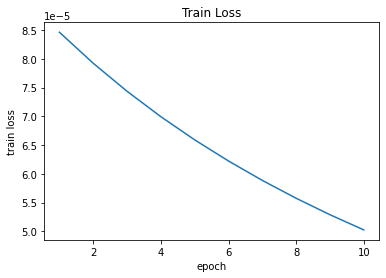

In [27]:
res_train(epoch,Resnet18,optimizer18)

training on:cuda
Train Epoch:1	train loss:0.000048
Train Epoch:2	train loss:0.000043
Train Epoch:3	train loss:0.000040
Train Epoch:4	train loss:0.000037
Train Epoch:5	train loss:0.000034
Train Epoch:6	train loss:0.000032
Train Epoch:7	train loss:0.000029
Train Epoch:8	train loss:0.000028
Train Epoch:9	train loss:0.000026
Train Epoch:10	train loss:0.000024


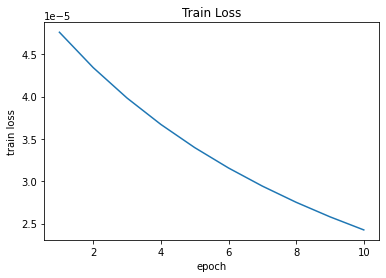

In [65]:
res_train(epoch,Resnet34,optimizer34)

# AlexNet

In [29]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(6400, 4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 2)
        )

    def forward (self, X):
        x= self.model(X)
        return x

In [30]:
Alexnet = AlexNet().to(device)
optimizer_alex = optim.Adam(Alexnet.parameters(), lr=0.0002)
loss_function = nn.CrossEntropyLoss()

In [31]:
def alex_train(epoch,model,optimizer):
    model.train()
    train_loss = []
    print("training on:{}".format(device))
    for i in range(epoch):
        train_loss.append(0)
        for batch_idx,(data,label) in enumerate(train_iter):
            data,label = data.to(device),label.to(device)
            optimizer.zero_grad()
            # 计算预测值
            output = model(data)
            # 计算损失值
            loss=loss_function(output,label)
            train_loss[i]+=loss.item()
            # 反向传播
            loss.backward()
            # 梯度更新
            optimizer.step()
        train_loss[i] /= (batch_idx+1)
        # 输出每轮epoch的训练误差
        print('Train Epoch:{}\ttrain loss:{:.6f}'.format(i+1,train_loss[i]))
    plt.title("Train Loss")
    plt.xlabel("epoch")
    plt.ylabel("train loss")
    x = np.arange(epoch)+1
    plt.plot(x,train_loss)
    plt.show()

training on:cuda
Train Epoch:1	train loss:0.000128
Train Epoch:2	train loss:0.000005
Train Epoch:3	train loss:0.000000
Train Epoch:4	train loss:0.000000
Train Epoch:5	train loss:0.000000
Train Epoch:6	train loss:0.000000
Train Epoch:7	train loss:0.000000
Train Epoch:8	train loss:0.000000
Train Epoch:9	train loss:0.000000
Train Epoch:10	train loss:0.000000


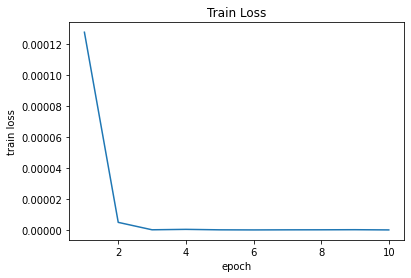

In [34]:
alex_train(epoch,Alexnet,optimizer_alex)

## GoogLeNet

In [35]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=2, aux_logits=True, init_weights=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

        if self.aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # N x 3 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        if self.training and self.aux_logits:    # eval model lose this layer
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 2 (num_classes)
        if self.training and self.aux_logits:   # eval model lose this layer
            return x, aux2, aux1
        return x


# Inception
class Inception(nn.Module):
    # 输入通道， 分支一的参数，分支二的两个参数，分支三的两个参数，分支四的参数
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)   # 保证输出大小等于输入大小
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)   # 保证输出大小等于输入大小
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        # 按照channel进行拼接
        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)

# InceptionAux 辅助分类层
class InceptionAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.averagePool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)  # output[batch, 128, 4, 4]

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = self.averagePool(x)
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.5, training=self.training)
        # N x 1024
        x = self.fc2(x)
        # N x num_classes
        return x

# 基础卷积层+激活层
class BasicConv2d(nn.Module):
    # 输入通道，输出通道，以及卷积用到的参数
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        return x

In [36]:
Googlenet = GoogLeNet().to(device)
optimizer_googlenet = optim.Adam(Googlenet.parameters(), lr=0.0003)
loss_function = nn.CrossEntropyLoss()

In [37]:
# 训练模块
def googlenet_train(epoch,model,optimizer):
    model.train()
    train_loss = []
    print("training on:{}".format(device))
    for i in range(epoch):
        train_loss.append(0)
        for batch_idx,(data,label) in enumerate(train_iter):
            data,label = data.to(device),label.to(device)
            optimizer.zero_grad()
            # 计算预测值
            logits, aux_logits2, aux_logits1 = model(data)
            # 计算损失值
            loss0 = loss_function(logits, label)
            loss1 = loss_function(aux_logits1, label)
            loss2 = loss_function(aux_logits2, label)
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3
            # 反向传播
            loss.backward()
            # 梯度更新
            optimizer.step()
            # 保存一轮下来的损失
            train_loss[i]+=loss.item()
        train_loss[i] /= (batch_idx+1)
        # 输出每轮epoch的训练误差
        print('Train Epoch:{}\ttrain loss:{:.6f}'.format(i+1,train_loss[i]))
    plt.title("Train Loss")
    plt.xlabel("epoch")
    plt.ylabel("train loss")
    x = np.arange(epoch)+1
    plt.plot(x,train_loss)
    plt.show()

training on:cuda
Train Epoch:1	train loss:0.000585
Train Epoch:2	train loss:0.000213
Train Epoch:3	train loss:0.000170
Train Epoch:4	train loss:0.000084
Train Epoch:5	train loss:0.000111
Train Epoch:6	train loss:0.000037
Train Epoch:7	train loss:0.000049
Train Epoch:8	train loss:0.000052
Train Epoch:9	train loss:0.000036
Train Epoch:10	train loss:0.000100


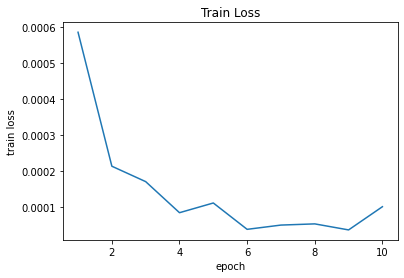

In [45]:
googlenet_train(epoch,Googlenet,optimizer_googlenet)

## Vision Transformer

In [46]:
class PatchEmbed(nn.Module):
    """
    2D Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_c=3, embed_dim=768, norm_layer=None):
        super().__init__()
        img_size = (img_size, img_size)
        patch_size = (patch_size, patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]

        self.proj = nn.Conv2d(in_c, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape

        # flatten: [B, C, H, W] -> [B, C, HW]
        # transpose: [B, C, HW] -> [B, HW, C]
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

In [47]:
class Attention(nn.Module):
    def __init__(self,
                 dim,   # 输入token的dim
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        # [batch_size, num_patches + 1, total_embed_dim]
        B, N, C = x.shape

        # qkv(): -> [batch_size, num_patches + 1, 3 * total_embed_dim]
        # reshape: -> [batch_size, num_patches + 1, 3, num_heads, embed_dim_per_head]
        # permute: -> [3, batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        # [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        # transpose: -> [batch_size, num_heads, embed_dim_per_head, num_patches + 1]
        # @: multiply -> [batch_size, num_heads, num_patches + 1, num_patches + 1]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # @: multiply -> [batch_size, num_heads, num_patches + 1, embed_dim_per_head]
        # transpose: -> [batch_size, num_patches + 1, num_heads, embed_dim_per_head]
        # reshape: -> [batch_size, num_patches + 1, total_embed_dim]
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

In [48]:
class Mlp(nn.Module):
    """
    MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [49]:
class Block(nn.Module):
    def __init__(self,
                 dim,
                 num_heads,
                 mlp_ratio=4.,
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

In [50]:
from functools import partial
class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_c=3, num_classes=2,
                 embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0, qkv_bias=True,
                 qk_scale=None, representation_size=None, distilled=False, drop_ratio=0.,
                 attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_c (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            qk_scale (float): override default qk scale of head_dim ** -0.5 if set
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_ratio (float): dropout rate
            attn_drop_ratio (float): attention dropout rate
            drop_path_ratio (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
        """
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(img_size=img_size, patch_size=patch_size, in_c=in_c, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_ratio)

        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(depth)
        ])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.has_logits = True
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ("fc", nn.Linear(embed_dim, representation_size)),
                ("act", nn.Tanh())
            ]))
        else:
            self.has_logits = False
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()



    def forward_features(self, x):
        # [B, C, H, W] -> [B, num_patches, embed_dim]
        x = self.patch_embed(x)  # [B, 196, 768]
        # [1, 1, 768] -> [B, 1, 768]
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)  # [B, 197, 768]
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)

        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x

In [51]:
def vit_base_patch16_224(num_classes: int = 2):
    model = VisionTransformer(img_size=224,
                              patch_size=16,
                              embed_dim=768,
                              depth=12,
                              num_heads=12,
                              representation_size=None,
                              num_classes=num_classes)
    return model

In [52]:
ViT = vit_base_patch16_224().to(device)
pg = [p for p in ViT.parameters() if p.requires_grad]
optimizer_vit = optim.SGD(pg, lr=0.001, momentum=0.9, weight_decay=5E-5)
loss_function = torch.nn.CrossEntropyLoss()

In [53]:
# 训练
def vit_train(epoch,model,optimizer):
    model.train()
    train_loss = []
    print("training on:{}".format(device))
    for i in range(epoch):
        train_loss.append(0)
        for batch_idx,(data,label) in enumerate(train_iter):
            data,label = data.to(device),label.to(device)
            optimizer.zero_grad()
            # 计算预测值
            output = model(data)
            # 计算损失值
            loss=loss_function(output,label)
            train_loss[i]+=loss.item()
            # 反向传播
            loss.backward()
            # 梯度更新
            optimizer.step()
        train_loss[i] /= (batch_idx+1)
        # 输出每轮epoch的训练误差
        print('Train Epoch:{}\ttrain loss:{:.6f}'.format(i+1,train_loss[i]))
    plt.title("Train Loss")
    plt.xlabel("epoch")
    plt.ylabel("train loss")
    x = np.arange(epoch)+1
    plt.plot(x,train_loss)
    plt.show()

training on:cuda
Train Epoch:1	train loss:0.000027
Train Epoch:2	train loss:0.000027
Train Epoch:3	train loss:0.000026
Train Epoch:4	train loss:0.000026
Train Epoch:5	train loss:0.000025
Train Epoch:6	train loss:0.000025
Train Epoch:7	train loss:0.000024
Train Epoch:8	train loss:0.000024
Train Epoch:9	train loss:0.000023
Train Epoch:10	train loss:0.000023


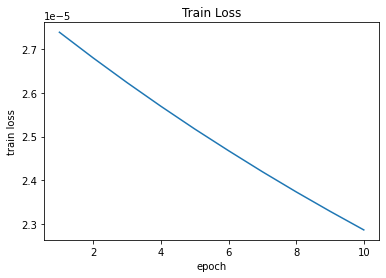

In [67]:
vit_train(epoch,ViT,optimizer_vit)

### 定义验证模块

In [73]:
def val(val_iter):
    Resnet18.eval()
    Resnet34.eval()
    Alexnet.eval()
    Googlenet.eval()
    ViT.eval()
    
    resnet18_correct = 0
    resnet34_correct = 0
    alexnet_correct = 0
    googlenet_correct = 0
    vit_correct = 0
    
    resnet18_val_acc = []
    resnet34_val_acc = []
    alexnet_val_acc = []
    googlenet_val_acc = []
    vit_val_acc = []
    print("result on {}".format(device))
    with torch.no_grad():
        for batch_idx,(data,label) in enumerate(val_iter):
            data,label = data.to(device),label.to(device)
            # 预测
            resnet18_output=Resnet18(data)
            resnet34_output=Resnet34(data)
            alexnet_output=Alexnet(data)
            googlenet_output=Googlenet(data)
            vit_output=ViT(data)
            # 计算类别
            resnet18_pred=resnet18_output.argmax(dim=1)
            resnet34_pred=resnet34_output.argmax(dim=1)
            alexnet_pred=alexnet_output.argmax(dim=1)
            googlenet_pred=googlenet_output.argmax(dim=1)
            vit_pred=vit_output.argmax(dim=1)
            
            for j in range(len(label)):
                if resnet18_pred[j]==label[j]:
                    resnet18_correct+=1
                if resnet34_pred[j]==label[j]:
                    resnet34_correct+=1
                if alexnet_pred[j]==label[j]:
                    alexnet_correct+=1
                if googlenet_pred[j]==label[j]:
                    googlenet_correct+=1
                if vit_pred[j]==label[j]:
                    vit_correct+=1
            resnet18_val_acc.append(resnet18_correct/((batch_idx+1)*60))
            resnet34_val_acc.append(resnet34_correct/((batch_idx+1)*60))
            alexnet_val_acc.append(alexnet_correct/((batch_idx+1)*60))
            googlenet_val_acc.append(googlenet_correct/((batch_idx+1)*60))
            vit_val_acc.append(vit_correct/((batch_idx+1)*60))
            # print("batch_idx:{},correct:{}".format(batch_idx+1,resnet18_correct/((batch_idx+1)*60)))
        plt.title("Val Acc")
        plt.xlabel("epoch")
        plt.ylabel("val acc")
        x = np.arange(batch_idx+1)+1
        plt.plot(x,resnet18_val_acc,label='resnet18',color='blue')
        plt.plot(x,resnet34_val_acc,label='resnet34',color='green')
        plt.plot(x,alexnet_val_acc,label='Alexnet',color='black')
        plt.plot(x,googlenet_val_acc,label='Googlenet',color='yellow')
        plt.plot(x,vit_val_acc,label='Vision Transformer',color='red')
        plt.legend()
        plt.show()
        print("resnet18 acc:{:.2f}%\n".format(resnet18_val_acc[batch_idx]*100))
        print("resnet34 acc:{:.2f}%\n".format(resnet34_val_acc[batch_idx]*100))
        print("alexnet acc:{:.2f}%\n".format(alexnet_val_acc[batch_idx]*100))
        print("googlenet acc:{:.2f}%\n".format(googlenet_val_acc[batch_idx]*100))
        print("Vision Transformer acc:{:.2f}%\n".format(vit_val_acc[batch_idx]*100))

result on cuda


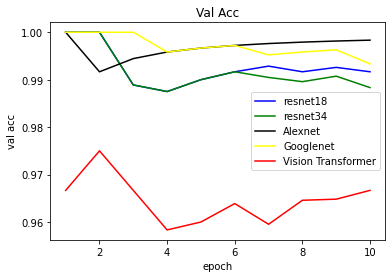

resnet18 acc:99.17%

resnet34 acc:98.83%

alexnet acc:99.83%

googlenet acc:99.33%

Vision Transformer acc:96.67%



In [74]:
val(val_iter)

### 测试预测模块

In [117]:
def test(test_loader):
    model.eval()
    
    result = []
    with torch.no_grad():
        for _,(data,label) in enumerate(test_loader):
            data,label = data.to(device),label.to(device)
            output = model(data)
            pred=output.argmax(dim=1)
            if pred==0:
                pred=-1
            elif pred==1:
                pred=1
            result.append(pred)
        return result

### 读入测试集

In [76]:
'''调用自己的Dataset类来读取数据'''
test_dataset = MyDataset(csv_file="../input/bitmoji-faces-gender-recognition/sample_submission.csv",
                          root_dir="../input/bitmoji-faces-gender-recognition/BitmojiDataset/testimages",
                          transform=data_transform)
'''将读取好的数据进行加载'''                          
test_iter = torch.utils.data.DataLoader(test_dataset) # 加载测试集

In [119]:
result = test(test_iter)

In [78]:
result_csv = pd.read_csv("../input/bitmoji-faces-gender-recognition/sample_submission.csv")

In [79]:
for i in range(len(result_csv)):
    result_csv.loc[i,'is_male'] = result[i]

In [80]:
result_csv.to_csv('./sample_submission.csv')